In [5]:
# Takes a minute to run this cell
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [129]:
# Import block
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier # binary classifier
from sklearn.model_selection import StratifiedKFold # manual x-validation
from sklearn.base import clone # manual x-validation
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_predict # For making predictions on the training set
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve # plots precision and recall as a function of decision threshold
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier # Multiclass classification

In [12]:
X, y = mnist["data"], mnist["target"]
# X is 70,000 x 784
# y is a vector of 70,000

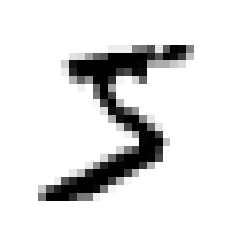

In [98]:
# Visualize one digit from the dataset
some_digit = np.array(X.iloc[0])
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis('off')
plt.show()

In [27]:
# What digit does this correspond to in MNIST?
y[0]

'5'

In [29]:
# The labels are strings; convert them to numbers
y = y.astype(np.uint8)

In [30]:
# Create training and testing data set
X_train, X_test, y_train, y_test = np.array(X.iloc[:60000]), np.array(X.iloc[60000:]), np.array(y[:60000]), np.array(y[60000:])

In [32]:
# Make our binary classifier. It will classify whether a digit is '5' or not.
# Create target vectors that are 1 if the image is a '5', and 0 otherwise.
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [37]:
# Use a stochastic gradient descent binary classifier
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [39]:
# Now, use it to predict if our image is a '5' or not.
sgd_clf.predict([some_digit])

array([ True])

In [46]:
# Implement cross validation, instead of usint cross_val_score()
skfolds = StratifiedKFold(n_splits = 3)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [49]:
# Use scikit-learn's cross validation score function
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [54]:
# So, the classifier looks deceivingly good. However, a classifier that always classifies a number as 'not 5'
# will also score pretty well. This will lead to skewed classes.
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [59]:
# Make the confusion matrix, which is essentially the matrix of true posititives, true negatives, false positives, 
# and false negatives.
# For this, we need a set of predictions. Let's not use the test set yet, but get a set of predictions on the training 
# set.
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)
# First row is 'non-5' images; first column is true negatives, second column is false positives. 687 images
#    were classified wrongly as '5'.
# Second row is '5' images; first column represents false negatives. 1891 images were wrongly classified as 'non-5'.
#    The second column represents true positives.

array([[53892,   687],
       [ 1891,  3530]])

In [63]:
# What are the precision and recall?
print(precision_score(y_train_5, y_train_pred))
print(3530./(687. + 3530.)) # Should give precision
print(recall_score(y_train_5, y_train_pred))
print(3530./(1891. + 3530.))

# So our SGD classifier has 83% precision, but 65% recall. 
# Precision means few false positives, recall means few false negatives

0.8370879772350012
0.8370879772350012
0.6511713705958311
0.6511713705958311


In [65]:
# And the f-score?
print(f1_score(y_train_5, y_train_pred))
print(3530./(3530. + 0.5*(1891. + 687.)))

0.7325171197343846
0.7325171197343847


In [69]:
# The classifier assigns a score to each digit. The higher the score, the more likely it's a '5'.
# predict() uses a threshold of 0
threshold = 0
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores) # 2164.22
y_some_digit_pred = (y_scores > threshold) # True
print(y_some_digit_pred)

# Raise the threshold. This decreases the recall (turns a true positive into a false negative)
threshold = 200000
y_some_digit_pred = (y_scores > threshold) # False
print(y_some_digit_pred)

[2164.22030239]
[ True]
[2164.22030239]
[False]


In [76]:
# Which threshold to use? Compute the scores for all instances in the training set.
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

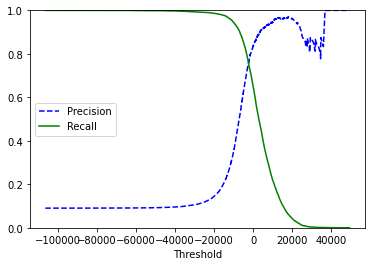

In [73]:
# Plot precisiona nd recall vs thresholds
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], 'g-', label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0,1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

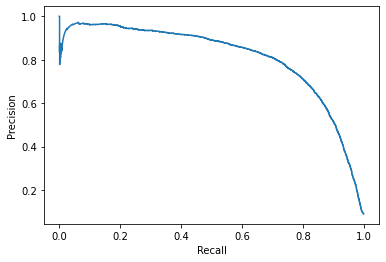

In [75]:
# Plot precision vs recall
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [80]:
# We can look up thresholds based on desired precision and recall. Say we want 90% precision, that corresponds
# to a threshold of about 3,000 on the precision, recall vs. threshold curve.
y_train_pred_90 = (y_scores > 3000)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.8911317008603574
0.4967718133185759


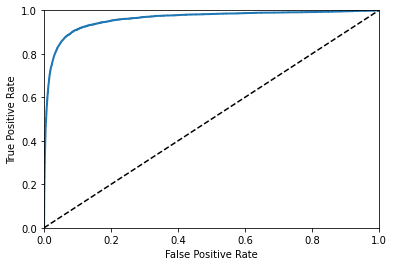

In [84]:
# Plot the receiving operating curve (ROC).
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth = 2, label=label)
    plt.plot([0,1],[0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

In [87]:
# A perfect classifier will have the area under the curve (AUC) of the ROC curve 1.
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [90]:
# Now, let's train a random forest classifier.
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
print(y_probas_forest)

[[0.11 0.89]
 [0.99 0.01]
 [0.96 0.04]
 ...
 [0.02 0.98]
 [0.92 0.08]
 [0.94 0.06]]


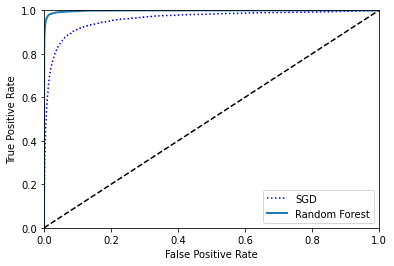

0.9983436731328145


In [93]:
# Use the probabilities for the positive class as scores
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

# Compare with the SGD
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc='lower right')
plt.show()

# Get the AUC for the Random Forest
print(roc_auc_score(y_train_5, y_scores_forest))

In [94]:
# Multiclass Classification
# Run the SGD on the whole training set. sklearn automatically detects we are doing multiclass classification
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint64)

In [105]:
# Well, this time, it didn't do so well. It thinks that the number is a '3'
# sklearn trained 10 classifiers; (One vs. All method) To see how each classifier did, do the following.
some_digit_scores = sgd_clf.decision_function([some_digit])
print(some_digit_scores)
print(np.argmax(some_digit_scores))
print(sgd_clf.classes_[3])

[[-31893.03095419 -34419.69069632  -9530.63950739   1823.73154031
  -22320.14822878  -1385.80478895 -26188.91070951 -16147.51323997
   -4604.35491274 -12050.767298  ]]
3
3


In [108]:
# Force One vs One classification (it'll make a pair of each of the different classes; here, there will be n*(n-1)/2
# in other words 45 classifiers.
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state = 42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

# This one gets it right.

array([5], dtype=uint64)

In [109]:
# Train a random forest classifier
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint64)

In [111]:
# See what probabilities the random forest classifier assigned to each class.
forest_clf.predict_proba([some_digit])

# It gives an 8% chance of this digit being a '3', 90% chance of it being a '5'

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

In [112]:
# Get cross validation score of the sgd classifier
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [115]:
# Scale the data to get better results
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [139]:
# Look at the confusion matrix
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_matrix = confusion_matrix(y_train, y_train_pred)
print(conf_matrix)

[[5577    0   22    5    8   43   36    6  225    1]
 [   0 6400   37   24    4   44    4    7  212   10]
 [  27   27 5220   92   73   27   67   36  378   11]
 [  22   17  117 5227    2  203   27   40  403   73]
 [  12   14   41    9 5182   12   34   27  347  164]
 [  27   15   30  168   53 4444   75   14  535   60]
 [  30   15   42    3   44   97 5552    3  131    1]
 [  21   10   51   30   49   12    3 5684  195  210]
 [  17   63   48   86    3  126   25   10 5429   44]
 [  25   18   30   64  118   36    1  179  371 5107]]


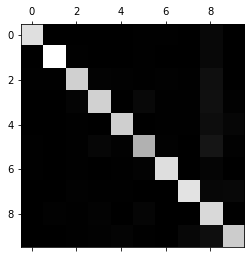

In [140]:
plt.matshow(conf_matrix, cmap=plt.cm.gray)
plt.show()

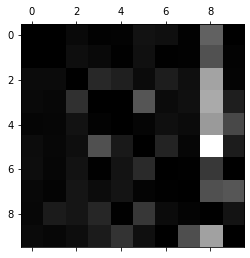

In [120]:
# Mute the true positives on the main diagonal.
row_sums = conf_matrix.sum(axis=1, keepdims=True)
norm_conf_matrix = conf_matrix / row_sums
np.fill_diagonal(norm_conf_matrix, 0)
plt.matshow(norm_conf_matrix, cmap=plt.cm.gray)
plt.show()

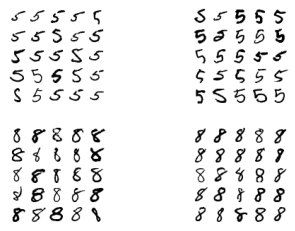

In [147]:
# Let's plot some '5's and '8's 
cl_a, cl_b = 5, 8
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

# Function taken from https://github.com/ageron/handson-ml/blob/master/03_classification.ipynb
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
    
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    
    
plt.subplot(221); plot_digits(X_aa[:25], images_per_row = 5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row = 5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row = 5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row = 5)
plt.show()

In [132]:
# Multilabel Classification
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd] # np.c_ concatenates along axis=1, i.e. np.c_([1,2,3], [4,5,6]) = [1,2,3,4,5,6]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([some_digit])

array([[False,  True]])

In [149]:
# Measure the f1 score for each individual label, and compute the average score
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
print(f1_score(y_multilabel, y_train_knn_pred, average="macro"))



0.976410265560605
[[False  True]
 [False False]
 [False False]
 ...
 [False  True]
 [False False]
 [ True False]]


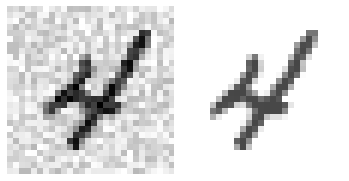

In [152]:
# Multioutput Classification
# Build a system that removes noise from the system. 
# Input is a noisy image
# Output is an array of pixel intensities, representing the cleaned image.
# The classifier is multilabel (one label per pixel), and each label can take on a value between 0 and 255
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test
    
# Visualize the noisy image
plot_digits([X_train_mod[9], X_train[9]])

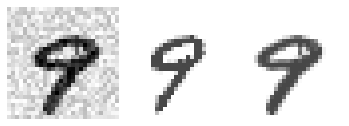

In [165]:
# Train a k-Nearest Neighbors Classifier
# knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[9]])
plot_digits([X_test_mod[9], clean_digit, y_test_mod[9]])

# Exercises

## Exercise 1 - Build and MNIST Classifier that gets over 97% accuracy on the test set

In [194]:
# Do a grid search on weights and n_neighbours
n_neighbors = range(5,10)
weights = ['uniform', 'distance']
cross_validation_scores = []
k_nearest_neighbours_classifiers = []
for n in n_neighbors:
    for w in weights:
        knn_clf = KNeighborsClassifier(n_neighbors = n, weights = w)
        k_nearest_neighbours_classifiers.append(knn_clf)
        knn_clf.fit(X_train, y_train)
        cvs = cross_val_score(knn_clf, X_train, y_train, cv=3, scoring="accuracy")
        cross_validation_scores.append(cvs)

In [193]:
cross_validation_scores = np.array(cross_validation_scores).reshape(5,2,3)
print(cross_validation_scores)
print(cross_validation_scores[1,1,0])
k_nearest_neighbours_classifiers = np.array(k_nearest_neighbours_classifiers).reshape(5,2)
k_nearest_neighbours_classifiers[1,1].get_params()

[[[0.9676  0.9671  0.96755]
  [0.9688  0.96795 0.96905]]

 [[0.9654  0.9652  0.9659 ]
  [0.97005 0.96855 0.96985]]

 [[0.9649  0.9646  0.9661 ]
  [0.967   0.9656  0.9674 ]]

 [[0.96365 0.9637  0.9657 ]
  [0.96715 0.9662  0.96845]]

 [[0.96355 0.9629  0.965  ]
  [0.96485 0.96405 0.96615]]]
0.97005


{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 6,
 'p': 2,
 'weights': 'distance'}

`n_neighbors = 6` and `weights = distance` give an accuracy of 97.1%. Not a pretty solution. For a better solution, use `GridSearchCV`

# Exercise 2 - Data Augmentation
Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. Use `shift` from `scipy.ndimage.interpolation`. Train the best model on this expanded training set.

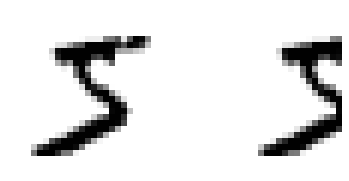

(300000, 784)


In [220]:
from scipy.ndimage.interpolation import shift

# Find out what shift does
some_digit_shifted = shift(some_digit.reshape(28,28), shift = [0, 10])
plot_digits([some_digit, some_digit_shifted])
plt.show()

def shift_image(digit, direction = [0,0]):
    # digit is (784,) array
    # direction is [number_of_pixels_to_shift_down, number_of_pixels_to_shift_right]
    shifted_image = shift(digit.reshape(28,28), shift = [direction[0], direction[1]])
    return shifted_image.reshape(784,)

left_shifted_digits = np.zeros(X_train.shape)
right_shifted_digits = np.zeros(X_train.shape)
up_shifted_digits = np.zeros(X_train.shape)
down_shifted_digits = np.zeros(X_train.shape)
for i in range(X_train.shape[0]):
    left_shifted_digits[i,:] = shift_image(X_train[i,:], [0, -1])
    right_shifted_digits[i,:] = shift_image(X_train[i,:], [0, 1])
    up_shifted_digits[i,:] = shift_image(X_train[i,:], [-1, 0])
    down_shifted_digits[i,:] = shift_image(X_train[i,:], [1, 0])

X_augmented_train = np.concatenate((X_train,
                                    left_shifted_digits,
                                    right_shifted_digits,
                                    up_shifted_digits,down_shifted_digits), axis=0)

In [228]:
# Augment the training targets
y_augmented_train = np.concatenate((y_train,)*5)

In [232]:
knn_clf = KNeighborsClassifier(n_neighbors = 2, weights = 'distance')
knn_clf.fit(X_augmented_train, y_augmented_train)

KNeighborsClassifier(n_neighbors=2, weights='distance')

In [233]:
cross_val_score(knn_clf, X_augmented_train, y_augmented_train, cv=2, scoring="accuracy")

array([0.96682   , 0.98198667])